### Math 168 Project - Part 4 Network Robustness & Failure Simulations

##### Objective: 
Test how information flow collapses under node removal (platform failure, banning users, user choice to leave social media, etc.).
##### Methods:
Simulate random vs. targeted node removal (removing random users vs. removing top influencers).
Measure how fast the network disintegrates (size of the giant component after failure).
Analyze post-collapse diffusion efficiency: Does the remaining network still allow information to spread? This part might involve re-running the code from part 1 or 2.
##### Analysis: 
If Google+ was more fragile under attack, it could explain why its user engagement was unsustainable.

In [5]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp

#### Graph Processing

In [ ]:
# Graph Processing for G+ and Facebook

def load_ego_network(ego_id, base_path, directed=False):
    edge_file = os.path.join(base_path, f"{ego_id}.edges")

    # Create graph (directed for G+, undirected for Facebook)
    G = nx.DiGraph() if directed else nx.Graph()

    with open(edge_file, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
            # if not directed:
            #     G.add_edge(node2, node1)  # Ensure undirected edges are bidirectional
    return G

facebook_base_path = os.getenv("FACEBOOK_BASE_PATH")
gplus_base_path = os.getenv("GPLUS_BASE_PATH")

facebook_ego_id = "0"  
gplus_ego_id = "100466178325794757407" 
# gplus_ego_id = "113455290791279442483" -- Ignore

G_fb = load_ego_network(facebook_ego_id, facebook_base_path, directed=False)
G_gplus = load_ego_network(gplus_ego_id, gplus_base_path, directed=True)

print(f"Facebook Ego Network ({facebook_ego_id}): {len(G_fb.nodes)} nodes, {len(G_fb.edges)} edges")
print(f"Google+ Ego Network ({gplus_ego_id}): {len(G_gplus.nodes)} nodes, {len(G_gplus.edges)} edges")

Facebook Ego Network (0): 333 nodes, 2519 edges
Google+ Ego Network (100466178325794757407): 344 nodes, 4178 edges


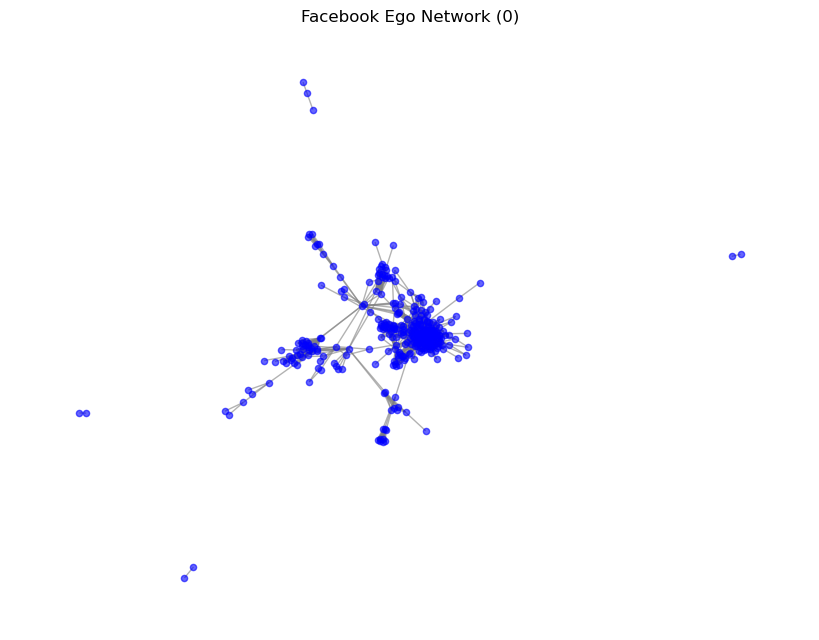

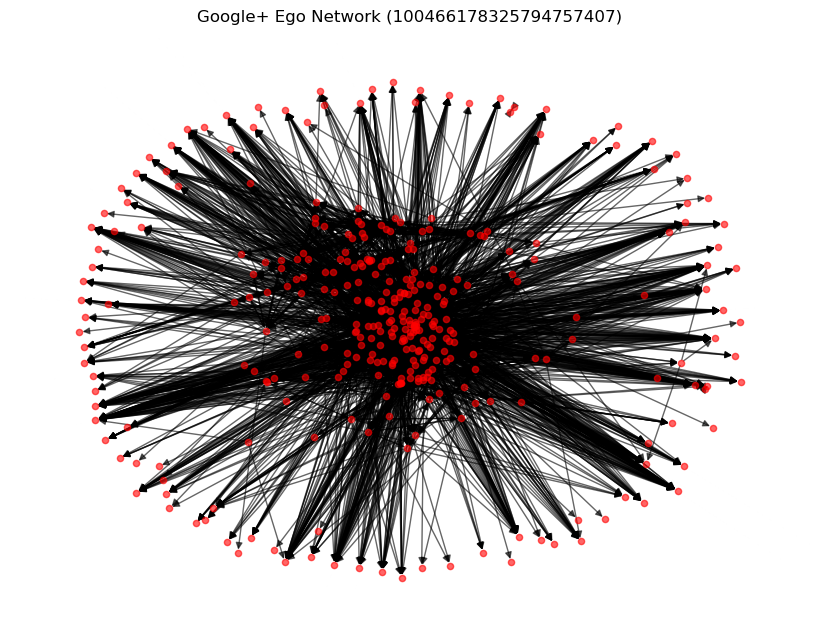

In [7]:
def visualize_network(G, title, node_color='blue', edge_color='gray', figsize=(8, 6)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=False, node_size=20, node_color=node_color, edge_color=edge_color, alpha=0.6)
    plt.title(title)
    plt.show()


visualize_network(G_fb, f"Facebook Ego Network ({facebook_ego_id})", node_color='blue', edge_color='gray')
visualize_network(G_gplus, f"Google+ Ego Network ({gplus_ego_id})", node_color='red', edge_color='black')

#### 1. Node removal simulation functions

BACKGROUND:
In real-world social networks, users can leave platforms for various reasons:
1. Random departure: Users leave for personal reasons unrelated to network structure
2. Targeted departure: High-influence users (celebrities, content creators) leave first,
   potentially triggering cascading departures

MOTIVATION:
Different network structures respond differently to these departure patterns.
Resilient networks maintain connectivity despite user losses, while fragile networks
quickly fragment. This analysis helps identify if Google+ had structural vulnerabilities
that Facebook didn't have, potentially explaining its inability to retain users.

In [8]:
# 1. Node removal simulation functions
def simulate_random_node_removal(G, fraction_to_remove):
    """Simulate random node removal from the network"""
    G_copy = G.copy()
    n = len(G_copy.nodes())
    nodes_to_remove = random.sample(list(G_copy.nodes()), int(fraction_to_remove * n))
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy

In [9]:
def simulate_targeted_node_removal(G, fraction_to_remove, centrality_measure='degree'):
    """Simulate targeted node removal based on centrality measures"""
    G_copy = G.copy()
    n = len(G_copy.nodes())
    num_to_remove = int(fraction_to_remove * n)
    
    # Calculate appropriate centrality measure
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(G_copy)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(G_copy)
    elif centrality_measure == 'eigenvector':
        try:
            centrality = nx.eigenvector_centrality(G_copy, max_iter=300)
        except:
            print("Eigenvector centrality calculation failed, falling back to degree centrality")
            centrality = nx.degree_centrality(G_copy)
    else:
        raise ValueError("Unsupported centrality measure")
    
    # Sort nodes by centrality (highest first)
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    nodes_to_remove = [node for node, _ in sorted_nodes[:num_to_remove]]
    
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy

#### 2. Measure network collapse 

BACKGROUND:
When users leave a social network, the network's structure changes in ways that can
affect its functionality. Key metrics help us understand this degradation:
- Giant component size: The largest connected group of users
- Path length: How many "hops" information needs to travel
- Clustering: Local density of connections
- Efficiency: How quickly information can spread

MOTIVATION:
For social networks, maintaining a large, well-connected giant component is crucial.
If removing a small fraction of users causes the network to fragment into isolated
communities, the platform becomes less valuable to remaining users, potentially
triggering more departures. This analysis reveals how quickly each network degrades
under pressure and which structure is more resilient.

In [10]:
def measure_network_robustness(G, removal_type='random', centrality_measure='degree', steps=10):
    """
    Measure how the network disintegrates under progressive node removal
    
    Parameters:
    G: networkx graph
    removal_type: 'random' or 'targeted'
    centrality_measure: used for targeted removal ('degree', 'betweenness', 'eigenvector')
    steps: number of removal steps to perform
    
    Returns:
    Dictionary of metrics at each removal fraction
    """
    is_directed = G.is_directed()
    fractions = np.linspace(0.1, 0.9, steps)  # Remove 10% to 90% of nodes
    
    results = {
        'fraction_removed': fractions,
        'giant_component_size': [],
        'num_components': [],
        'avg_path_length': [], 
        'clustering_coefficient': [],
        'efficiency': []
    }
    
    for fraction in fractions:
        if removal_type == 'random':
            G_remaining = simulate_random_node_removal(G, fraction)
        else:  # targeted
            G_remaining = simulate_targeted_node_removal(G, fraction, centrality_measure)
        
        # If the graph is directed, convert to undirected for some metrics
        G_undirected = G_remaining.to_undirected() if is_directed else G_remaining
        
        # Calculate metrics
        if len(G_remaining.nodes()) > 0:
            # Find the largest connected component
            if is_directed:
                components = list(nx.weakly_connected_components(G_remaining))
            else:
                components = list(nx.connected_components(G_remaining))
            
            largest_cc = max(components, key=len)
            giant_component_size = len(largest_cc) / len(G.nodes())  # Normalized by original size
            
            results['giant_component_size'].append(giant_component_size)
            results['num_components'].append(len(components))
            
            # Create subgraph of largest component for path calculations
            largest_cc_graph = G_undirected.subgraph(largest_cc)
            
            # Average path length (if the component is connected)
            try:
                results['avg_path_length'].append(nx.average_shortest_path_length(largest_cc_graph))
            except:
                results['avg_path_length'].append(np.nan)
            
            # Clustering coefficient
            results['clustering_coefficient'].append(nx.average_clustering(G_undirected))
            
            # Global efficiency (inverse of average shortest path)
            try:
                efficiency = nx.global_efficiency(largest_cc_graph)
                results['efficiency'].append(efficiency)
            except:
                results['efficiency'].append(np.nan)
        else:
            # Empty graph case
            results['giant_component_size'].append(0)
            results['num_components'].append(0)
            results['avg_path_length'].append(np.nan)
            results['clustering_coefficient'].append(0)
            results['efficiency'].append(0)
            
    return results

#### 3. Information diffusion simulation

BACKGROUND:
Social networks derive value from their ability to spread information (posts, content,
messages) between users. Information diffusion models simulate how content spreads
through a network over time.

The Independent Cascade model used here assumes each user has one chance to "infect"
(share content with) their neighbors with a fixed probability.

MOTIVATION:
Even if a network remains connected after user departures, its ability to spread
information efficiently might degrade. This analysis measures how information diffusion
capability changes after different types of user removal, revealing whether
Google+ might have suffered from diminished content virality after key user departures.


In [11]:
def simulate_information_diffusion(G, seeds, p=0.1, steps=10):
    """
    Simulate information diffusion using independent cascade model
    
    Parameters:
    G: networkx graph
    seeds: list of seed nodes to start diffusion
    p: probability of infection
    steps: number of diffusion steps
    
    Returns:
    List of fraction of nodes infected at each step
    """
    # If seeds not in G (e.g., after node removal), select random nodes
    valid_seeds = [s for s in seeds if s in G.nodes()]
    if len(valid_seeds) == 0 and len(G.nodes()) > 0:
        valid_seeds = random.sample(list(G.nodes()), min(5, len(G.nodes())))
    
    infected = set(valid_seeds)
    newly_infected = set(valid_seeds)
    infection_history = [len(infected) / max(1, len(G.nodes()))]  # Normalized
    
    for _ in range(steps):
        current_newly_infected = set()
        
        for node in newly_infected:
            neighbors = set(G.neighbors(node)) if G.is_directed() else set(G.neighbors(node))
            susceptible_neighbors = neighbors - infected
            
            for neighbor in susceptible_neighbors:
                if random.random() < p:  # Infection probability
                    current_newly_infected.add(neighbor)
        
        infected.update(current_newly_infected)
        newly_infected = current_newly_infected
        
        infection_history.append(len(infected) / max(1, len(G.nodes())))
        
        # If no new infections or all nodes infected, stop simulation
        if len(newly_infected) == 0 or len(infected) == len(G.nodes()):
            break
    
    # Pad the history to match steps if stopped early
    infection_history.extend([infection_history[-1]] * (steps + 1 - len(infection_history)))
    return infection_history[:steps+1]

#### 4. Analyze and visualize results

BACKGROUND:
Network robustness analysis provides crucial insights for platform designers and managers.
Understanding how different network structures respond to user departures helps:
- Design more resilient social networks
- Identify early warning signs of potential platform collapse
- Develop strategies to mitigate cascading user departures

MOTIVATION:
Google+ failed to achieve sustained user engagement despite Google's resources and reach.
By comparing its network structure resilience to Facebook's, we can identify if
structural weaknesses contributed to its failure. This helps explain why some social
networks thrive while others fail, despite similar features and backing.

In [12]:
def run_robustness_analysis(G, name, num_steps=10):
    """Run comprehensive robustness analysis on a network"""
    print(f"\nRunning robustness analysis for {name} network...")
    
    # 1. Measure robustness under different removal strategies
    results_random = measure_network_robustness(G, removal_type='random', steps=num_steps)
    results_targeted_degree = measure_network_robustness(G, removal_type='targeted', 
                                                       centrality_measure='degree', steps=num_steps)
    
    # 2. Plot giant component size under node removal
    plt.figure(figsize=(10, 6))
    plt.plot(results_random['fraction_removed'], results_random['giant_component_size'], 
             'o-', label='Random Removal')
    plt.plot(results_targeted_degree['fraction_removed'], results_targeted_degree['giant_component_size'], 
             's-', label='Targeted Removal (Degree)')
    plt.xlabel('Fraction of Nodes Removed')
    plt.ylabel('Relative Size of Giant Component')
    plt.title(f'{name} Network Disintegration')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{name}_disintegration.png")
    plt.show()
    
    # 3. Plot efficiency under node removal
    plt.figure(figsize=(10, 6))
    plt.plot(results_random['fraction_removed'], results_random['efficiency'], 
             'o-', label='Random Removal')
    plt.plot(results_targeted_degree['fraction_removed'], results_targeted_degree['efficiency'], 
             's-', label='Targeted Removal (Degree)')
    plt.xlabel('Fraction of Nodes Removed')
    plt.ylabel('Network Efficiency')
    plt.title(f'{name} Network Efficiency Under Attack')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{name}_efficiency.png")
    plt.show()
    
    # 4. Analyze information diffusion before and after attack
    # Select seed nodes (e.g., top 5 by degree centrality)
    centrality = nx.degree_centrality(G)
    seed_nodes = [node for node, _ in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]]
    
    # Simulate on original network
    diffusion_original = simulate_information_diffusion(G, seed_nodes)
    
    # Simulate on networks after random and targeted removal (30% of nodes)
    G_random_removed = simulate_random_node_removal(G, 0.3)
    G_targeted_removed = simulate_targeted_node_removal(G, 0.3)
    
    diffusion_random = simulate_information_diffusion(G_random_removed, seed_nodes)
    diffusion_targeted = simulate_information_diffusion(G_targeted_removed, seed_nodes)
    
    # Plot diffusion curves
    plt.figure(figsize=(10, 6))
    plt.plot(diffusion_original, 'o-', label='Original Network')
    plt.plot(diffusion_random, 's-', label='After Random Removal (30%)')
    plt.plot(diffusion_targeted, '^-', label='After Targeted Removal (30%)')
    plt.xlabel('Time Steps')
    plt.ylabel('Fraction of Nodes Infected')
    plt.title(f'Information Diffusion in {name} Network')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{name}_diffusion.png")
    plt.show()
    
    return {
        'random': results_random, 
        'targeted': results_targeted_degree,
        'diffusion_original': diffusion_original,
        'diffusion_random': diffusion_random,
        'diffusion_targeted': diffusion_targeted
    }


#### 5. Compare Facebook and Google+ robustness

BACKGROUND:
The direct comparison of Facebook and Google+ network resilience provides insights into
the structural factors that might have contributed to their different outcomes. 
Facebook has maintained its position as a dominant social network, while Google+
shut down after failing to achieve sustainable engagement.

MOTIVATION:
Understanding the structural differences in robustness helps explain:
- Why Facebook maintained its user base despite competition
- Why Google+ failed to achieve sustained user engagement despite Google's resources
- How network structure influences platform sustainability
- What design choices might improve future social platforms' resilience

In [13]:
def compare_network_robustness(G1, name1, G2, name2):
    """Compare robustness metrics between two networks"""
    # Run analysis for both networks
    results1 = run_robustness_analysis(G1, name1)
    results2 = run_robustness_analysis(G2, name2)
    
    # Plot comparison of giant component disintegration
    plt.figure(figsize=(12, 6))
    
    # Random removal comparison
    plt.subplot(1, 2, 1)
    plt.plot(results1['random']['fraction_removed'], results1['random']['giant_component_size'], 
             'o-', label=name1)
    plt.plot(results2['random']['fraction_removed'], results2['random']['giant_component_size'], 
             's-', label=name2)
    plt.xlabel('Fraction of Nodes Removed')
    plt.ylabel('Relative Size of Giant Component')
    plt.title('Random Node Removal')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Targeted removal comparison
    plt.subplot(1, 2, 2)
    plt.plot(results1['targeted']['fraction_removed'], results1['targeted']['giant_component_size'], 
             'o-', label=name1)
    plt.plot(results2['targeted']['fraction_removed'], results2['targeted']['giant_component_size'], 
             's-', label=name2)
    plt.xlabel('Fraction of Nodes Removed')
    plt.ylabel('Relative Size of Giant Component')
    plt.title('Targeted Node Removal (Degree)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("network_comparison_disintegration.png")
    plt.show()
    
    # Compare final diffusion reach
    final_reach = {
        f"{name1}_original": results1['diffusion_original'][-1],
        f"{name1}_random": results1['diffusion_random'][-1],
        f"{name1}_targeted": results1['diffusion_targeted'][-1],
        f"{name2}_original": results2['diffusion_original'][-1],
        f"{name2}_random": results2['diffusion_random'][-1],
        f"{name2}_targeted": results2['diffusion_targeted'][-1]
    }
    
    # Plot final diffusion reach comparison
    plt.figure(figsize=(10, 6))
    plt.bar(final_reach.keys(), final_reach.values())
    plt.ylabel('Final Diffusion Reach (Fraction of Nodes)')
    plt.title('Information Diffusion Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("diffusion_comparison.png")
    plt.show()
    
    # Calculate and print robustness metrics
    def calculate_robustness_metric(results):
        """Calculate area under the giant component curve (higher is more robust)"""
        return np.trapz(results['giant_component_size'], results['fraction_removed'])
    
    robustness_metrics = {
        f"{name1}_random": calculate_robustness_metric(results1['random']),
        f"{name1}_targeted": calculate_robustness_metric(results1['targeted']),
        f"{name2}_random": calculate_robustness_metric(results2['random']),
        f"{name2}_targeted": calculate_robustness_metric(results2['targeted'])
    }
    
    print("\nRobustness Metrics (Area Under Giant Component Curve):")
    for network, metric in robustness_metrics.items():
        print(f"{network}: {metric:.4f}")
    
    return robustness_metrics



### Run the full comparison

DISCUSSION & IMPLICATIONS:

The results of this analysis can help explain:

1. Platform Sustainability: If Google+ shows significantly faster network
   disintegration under targeted attacks, this suggests its network structure was inherently
   more vulnerable to influencer departures, explaining its difficulty maintaining engagement.

2. Content Virality: Differences in post-attack information diffusion capacity may explain
   why content spread more effectively on Facebook, driving higher engagement.

3. Design Recommendations: The results suggest optimal network structures for future
   social platforms that balance growth with resilience to user departures.

4. Moderation Strategy: Understanding network robustness helps platforms make informed
   decisions about banning problematic users without triggering cascading departures.

These insights extend beyond just explaining Google+'s failure - they provide a framework
for analyzing and designing resilient social platforms in general.


Starting Network Robustness Analysis...

Running robustness analysis for Facebook network...


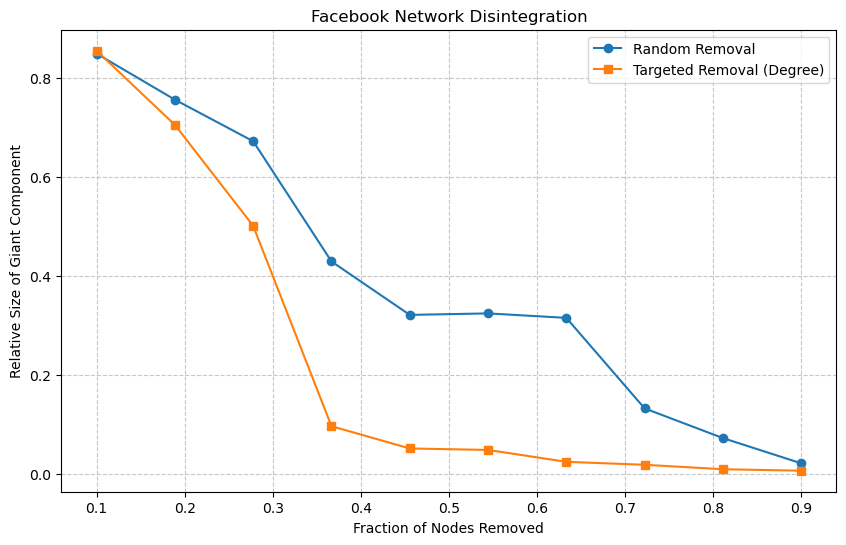

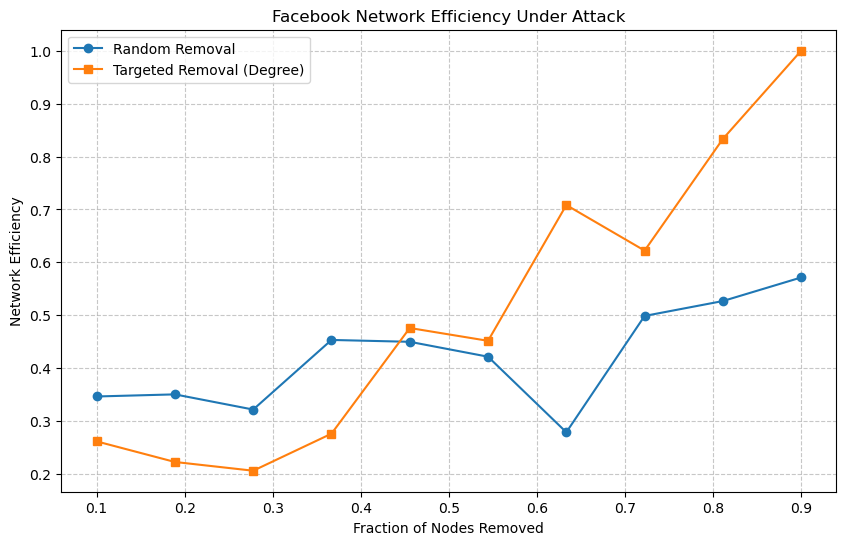

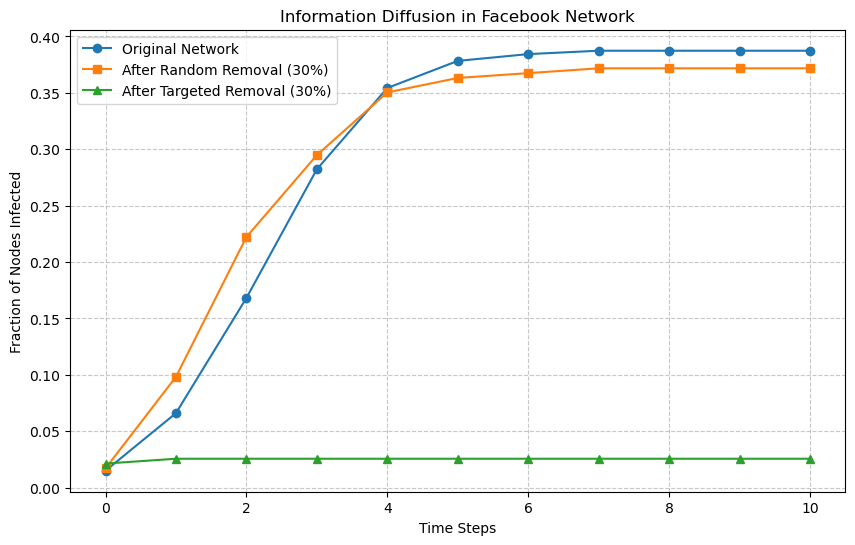


Running robustness analysis for Google+ network...


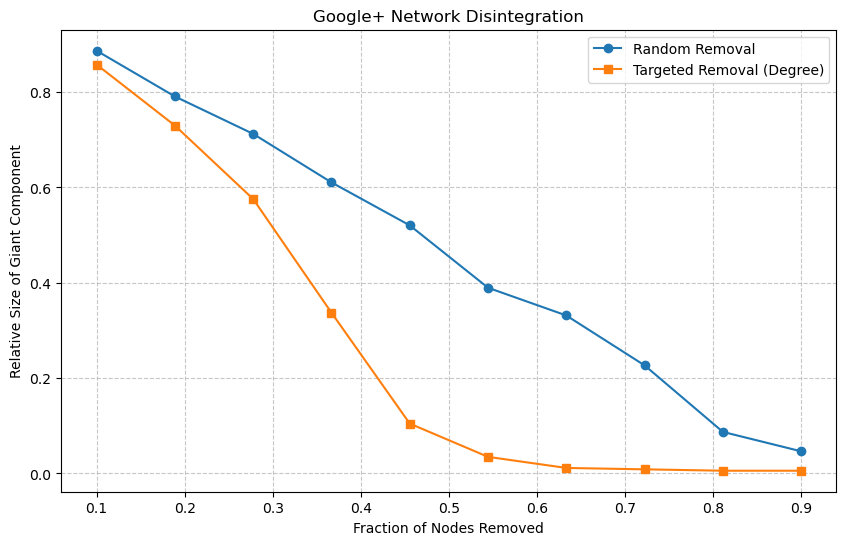

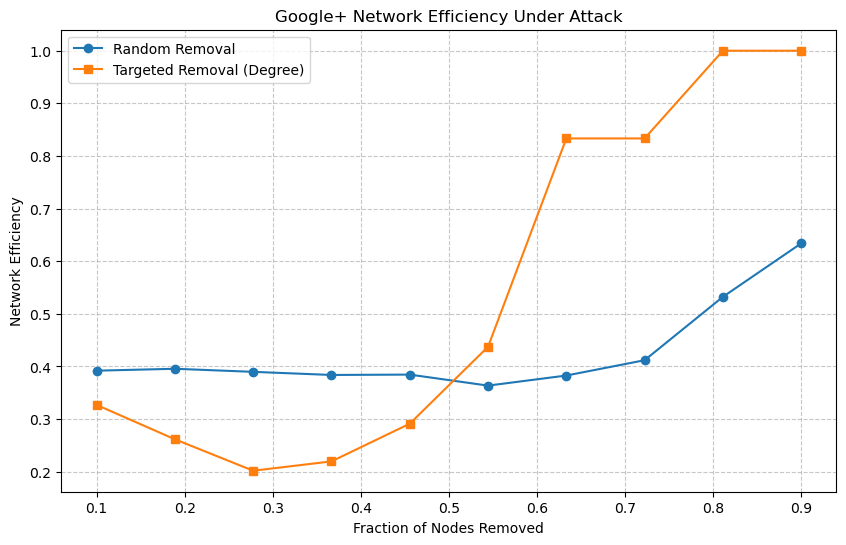

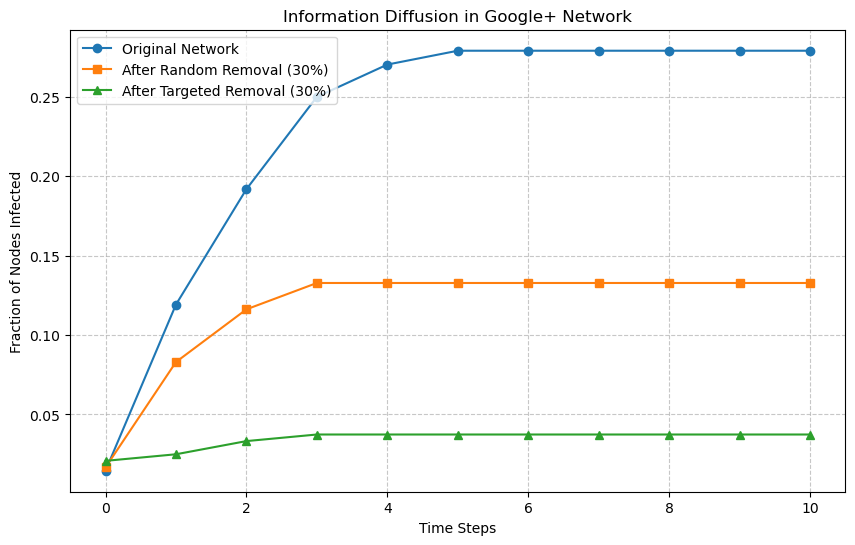

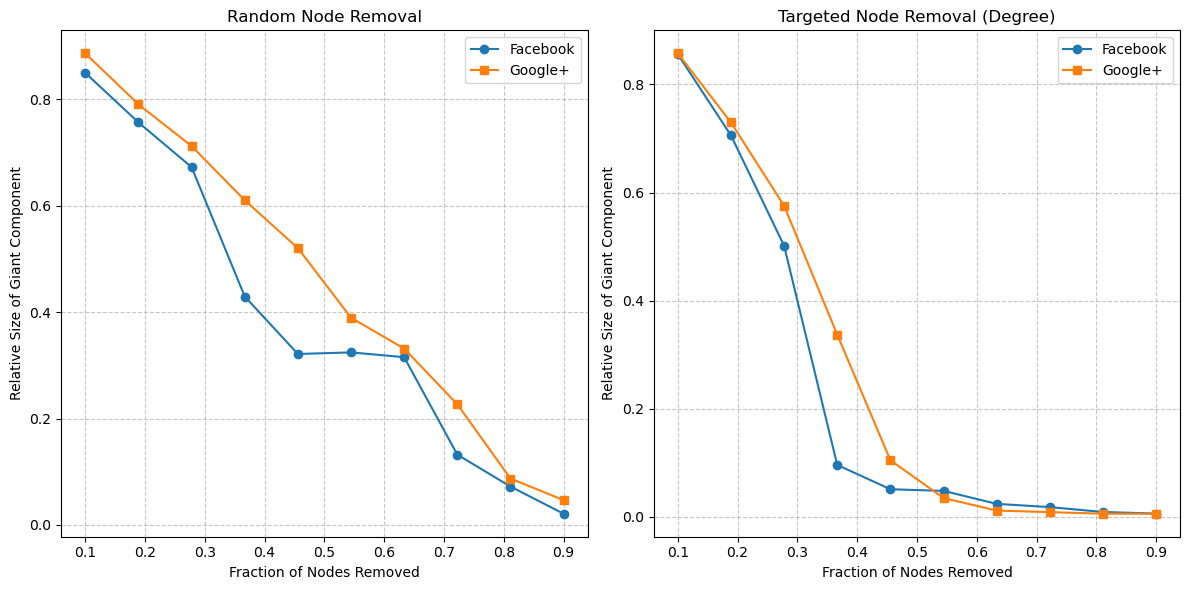

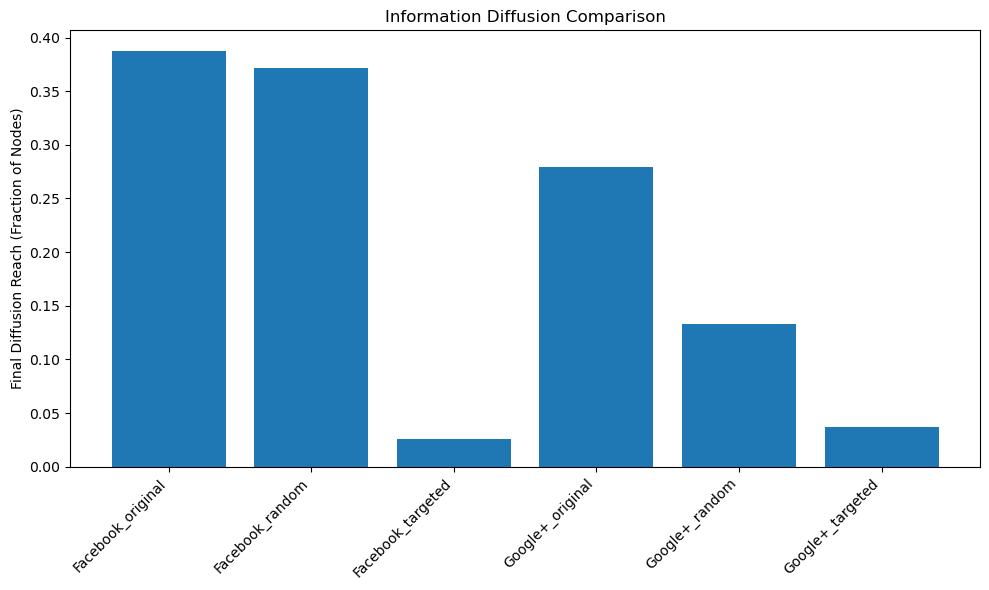


Robustness Metrics (Area Under Giant Component Curve):
Facebook_random: 0.3075
Facebook_targeted: 0.1675
Google+_random: 0.3676
Google+_targeted: 0.1991


{'Facebook_random': 0.3075075075075075,
 'Facebook_targeted': 0.16750083416750086,
 'Google+_random': 0.36757105943152457,
 'Google+_targeted': 0.19909560723514214}

In [14]:
# Run the full comparison
print("\nStarting Network Robustness Analysis...")
compare_network_robustness(G_fb, "Facebook", G_gplus, "Google+")